In [1]:
from os.path import join, exists
from os import makedirs
from glob import glob

import numpy as np
import pandas as pd

from tqdm import tqdm

import json

from PIL import Image, ImageFilter
from IPython.display import HTML

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, colors, animation

from joblib import Memory

In [2]:
from DRN import network, behav, fmri

In [3]:
DRN = fmri()

In [4]:
%matplotlib inline

---

In [5]:
import torch
from torch.distributions import Normal

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

---

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [7]:
subj = 'DRN04'
list_run = [ss.split('/')[-1] for ss in sorted(glob(join(DRN.dir_behav,subj,'Run?')))]

---

### Network

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [8]:
kernel = DRN.network.head.conv1.weight.detach().numpy()
kernel.shape

(32, 12, 8, 8)

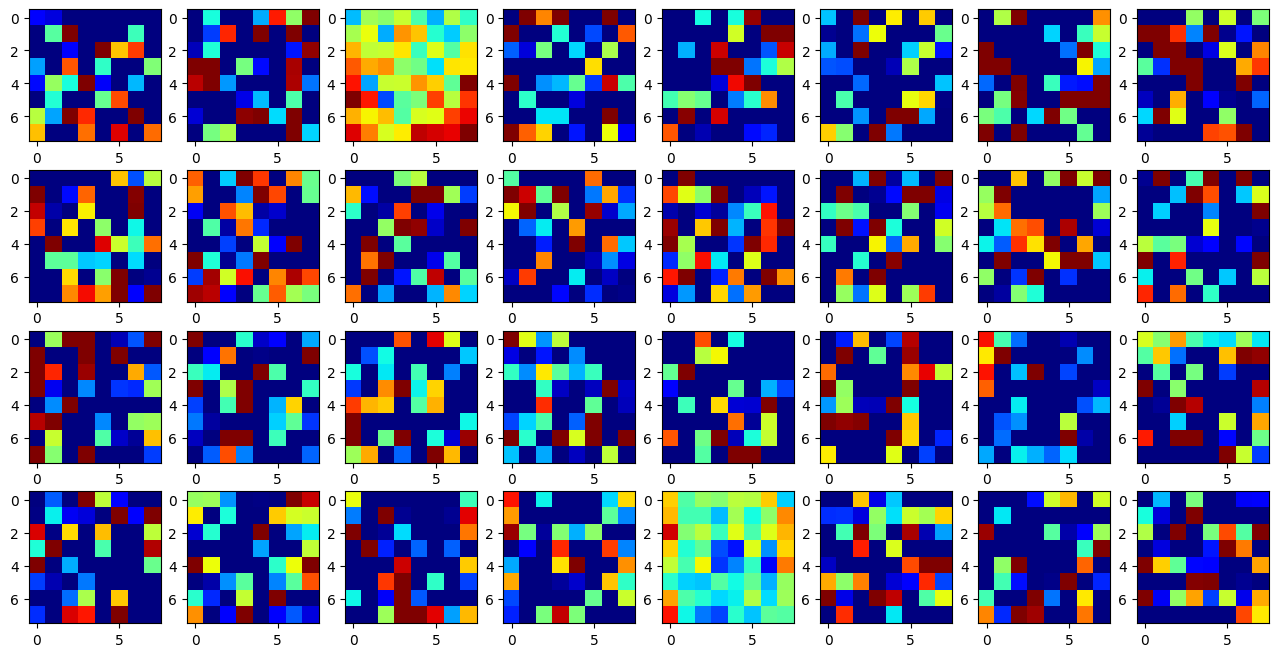

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=np.array([8,4])*2)
axs = np.concatenate(axs)

for ii, k in enumerate(kernel):
    ax = axs[ii]
    img = k.mean(axis=0)
#     img = k[1]
    ax.imshow(
        img,
        cmap='jet',
        vmin=-0.01, vmax=0.01
    )

---

In [10]:
dict_png, dict_onsettime, dict_action, dict_episode, dict_result = DRN.get_data_behav(subj=subj, list_run=list_run)

---

Make a GIF

In [11]:
# fig = plt.figure(figsize=np.array([12.8,7.2])*0.3)
# plt.axis('off')

# img = []
# for idx in range(10,140):
#     img.append(
#         [plt.imshow(Image.open(dict_png[run][idx]), animated=True)]
#     )

# ani = animation.ArtistAnimation(fig, img, interval=100)
# ani.save('/home/sungbeenpark/Github/labs/DRN/results/%s.gif'%subj, writer='imagemagick')

# HTML(ani.to_jshtml())

---

#### Forward

In [12]:
dir_cache = join(DRN.dir_cache,'forward')
makedirs(dir_cache, exist_ok=True)
memory = Memory(dir_cache, verbose=0)

In [13]:
@memory.cache
def do_forward(subj, list_run, run, shift=0):
    input_, output_ = DRN.do_forward(subj=subj, list_run=list_run, run=run, shift=shift)
    
    return input_, output_

---

#### Value function

Run1
x r=-0.068 p=0.015(*)
y r=-0.030 p=0.285(ns)
z r=0.121 p=0.000(****)
Run2
x r=-0.106 p=0.000(***)
y r=-0.027 p=0.325(ns)
z r=0.033 p=0.232(ns)
Run3
x r=-0.132 p=0.000(****)
y r=-0.011 p=0.704(ns)
z r=0.113 p=0.000(****)
Run4
x r=-0.115 p=0.000(****)
y r=0.003 p=0.917(ns)
z r=0.052 p=0.064(ns)
Run5
x r=-0.117 p=0.000(****)
y r=0.049 p=0.079(ns)
z r=0.122 p=0.000(****)
Run6
x r=-0.119 p=0.000(****)
y r=-0.043 p=0.126(ns)
z r=0.127 p=0.000(****)


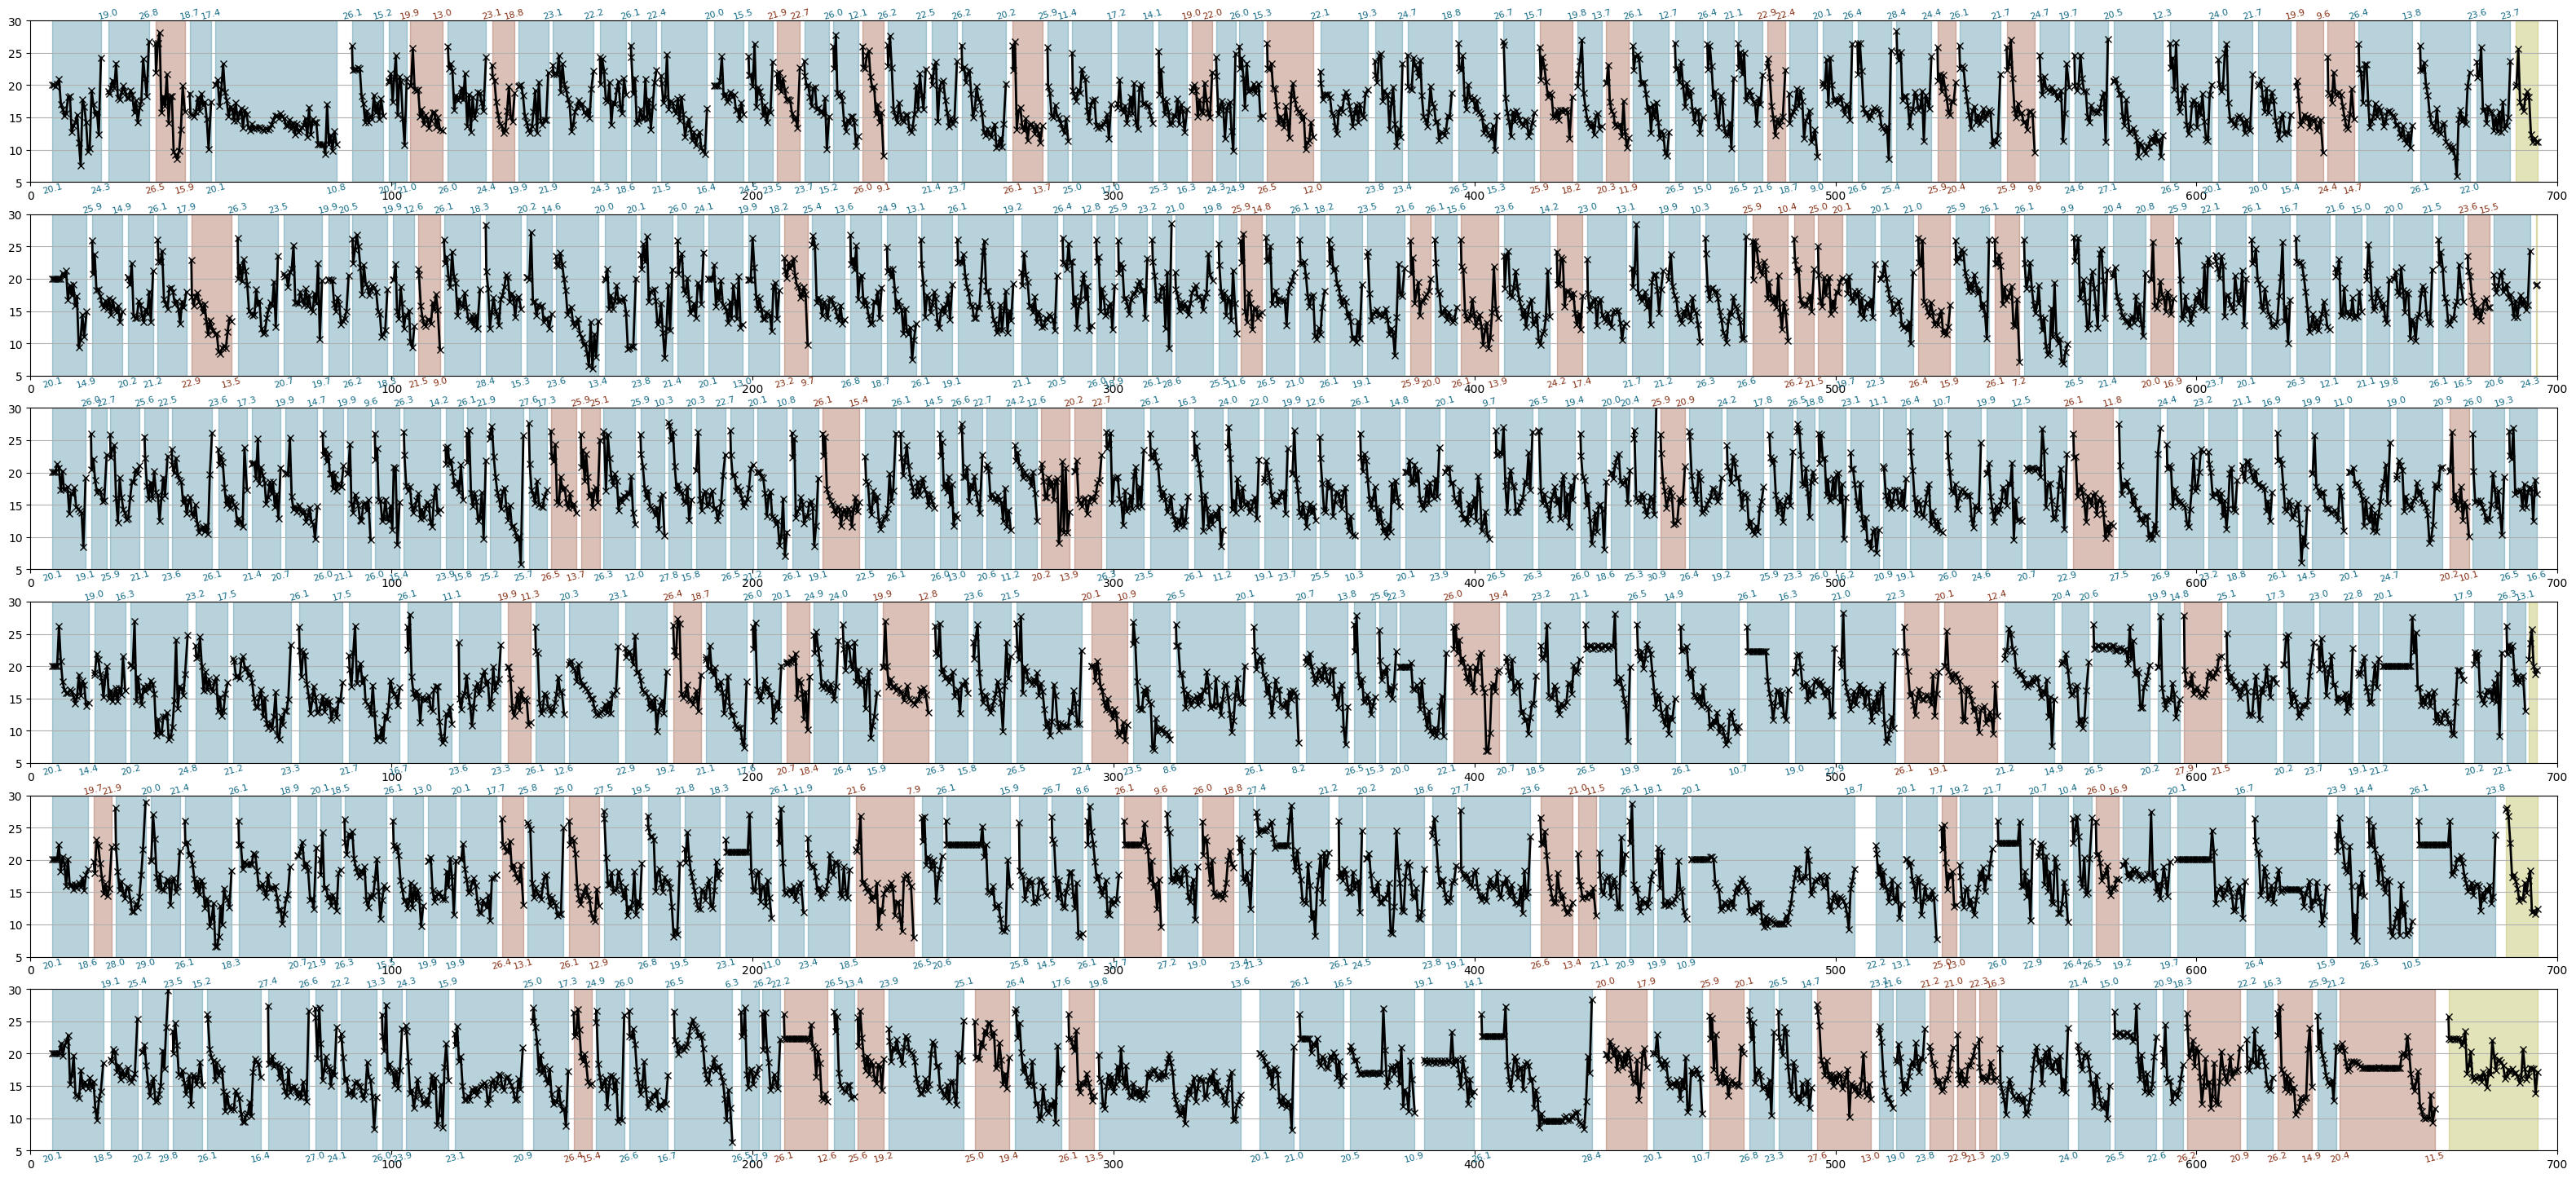

In [14]:
nrows=len(list_run)
fig, axs = plt.subplots(nrows=nrows, figsize=(40,nrows*3))

for rr, (run, onset) in enumerate(dict_onsettime.items()):
    
    ## ======================================================= ##

    ## forward
    input_, output_ = do_forward(subj, list_run, run, shift=5)
    ninput = input_.shape[0]
    (mu, std, val), _ = output_
    
    ## ======================================================= ##
    
    ## the first index of each input (Reduced data list)
    idx_input, idx_epi = DRN.get_idx_input(subj=subj, run=run, list_run=list_run, shift=0)
    for ii, (k, v) in enumerate(idx_input.items()):
        if ii > 0:
            idx_FirstShot = np.concatenate([idx_FirstShot, v[:,0]])
        else:
            idx_FirstShot = v[:,0]
    idx_FirstShot = idx_FirstShot[:ninput]
    
    ## onsettimes (Reduced data list)
    list_onsettime = dict_onsettime[run][idx_FirstShot]

    ## episode (Reduced data list)
    list_episode = dict_episode[run][idx_FirstShot][:ninput]
    
    ## success/failure (size = # of episodes)
    list_idx_terminal = np.where(np.diff(dict_episode[run]))[0]
    list_result = np.concatenate(
        [dict_result[run][list_idx_terminal+1], ['Yet']],
        axis=None
    )
    
    ## ======================================================= ##

    ## Action (Reduced data list)
    z = torch.normal(mu, std)
    action_pred = torch.tanh(z).numpy()
    
    action_real = dict_action[run][idx_FirstShot]
    
    ## value function (Reduced data list)
    list_value = np.squeeze(val.numpy())

    print(run)
    for ii, xx in enumerate(['x','y','z']):
        a = action_real[:,ii]
        b = action_pred[:,ii]
        r, p = stats.pearsonr(a,b)
        print(xx, 'r=%.3f'%r, 'p=%.3f(%s)'%(p,convert_pvalue_to_asterisks(p)))
    
    ## ======================================================= ##
    
    ## plot
    ax = axs[rr]
    for ii, episode in enumerate(np.unique(list_episode)):
        list_idx = np.where(list_episode==episode)[0]
        x = list_onsettime[list_idx]
        y = list_value[list_idx]
        ax.plot(
            x, y,
            marker='x',  markersize=6,
            linestyle='-', linewidth=2,
            color='black',
        )
        ## result
        res = list_result[ii]
        color = '#136A86' if res=='Success' else ('#862F13' if res=='Collided' else '#A4A31C')
        ax.fill_between(
            x=x,
            y1=0, y2=35,
            where=np.ones(x.shape),
            color=color, alpha=0.3
        )
        if res == 'Yet':
            continue
        
        if episode%2==0:
            h=5
            v='top'
        else:
            h=30
            v='bottom'
        ## the initial value function
        ax.text(
            x=x[0],
            y=h,
            s='%.1f'%y[0],
            fontdict={
                'fontsize':8,
                'color':color,
                'horizontalalignment':'center',
                'verticalalignment':v,
                'rotation':15
            }
        )
        ## the final value function
        ax.text(
            x=x[-1],
            y=h,
            s='%.1f'%y[-1],
            fontdict={
                'fontsize':8,
                'color':color,
                'horizontalalignment':'center',
                'verticalalignment':v,
                'rotation':15
            }
        )
        
    ylim = ax.get_ylim()
    ylim = (5,30)
    ax.set_xlim([0,700])
    ax.grid(axis='y')
    ax.set_ylim(ylim)

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/value_function.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

---

In [15]:
run = 'Run1'

In [16]:
shift = 0
input_, output_ = DRN.do_forward(subj, list_run, run, shift=shift)

(mu, std, val), (conv1, conv2, conv3) = output_

100%|██████████| 1295/1295 [00:01<00:00, 678.01it/s]


In [17]:
idx_input, idx_epi = DRN.get_idx_input(subj=subj, list_run=list_run, run=run, shift=shift)

for episode, tmp in idx_input.items():
    if episode=='episode:01':
        list_idx = tmp
    else:
        list_idx = np.concatenate((list_idx, tmp), axis=0)

---

In [23]:
training = False
z = torch.normal(mu, std) if training else mu
action = torch.tanh(z).cpu().numpy()

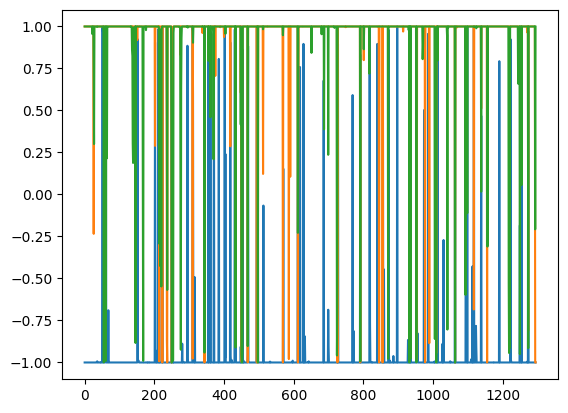

In [26]:
plt.plot(action)

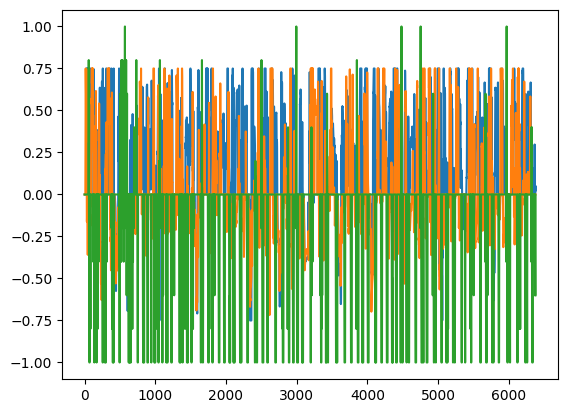

In [27]:
plt.plot(dict_action[run])

---

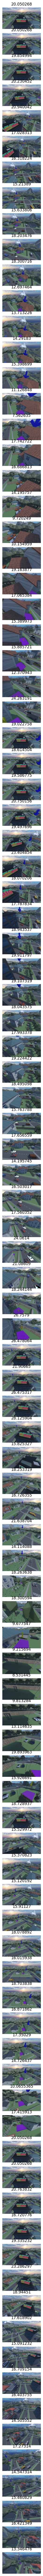

In [22]:
tmp = range(100)
nrows = len(tmp)
# ncols = 4
ncols = 1

ratio = 0.2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12.8*ncols*ratio, 7.2*nrows*ratio))

for ii, fnames in enumerate(dict_png[run][list_idx[tmp]]):
    scene = tmp[ii]
    onset = dict_onsettime[run][scene]
    for jj, fname in enumerate(fnames[:ncols]):
        if ncols > 1:
            ax = axs[ii][jj]
        else:
            ax = axs[ii]
        img = Image.open(fname)
        ax.imshow(img)
        ax.axis('off')
        if jj==0:
            ax.set_title(val[scene][0].numpy())

---

In [17]:
idx = 500

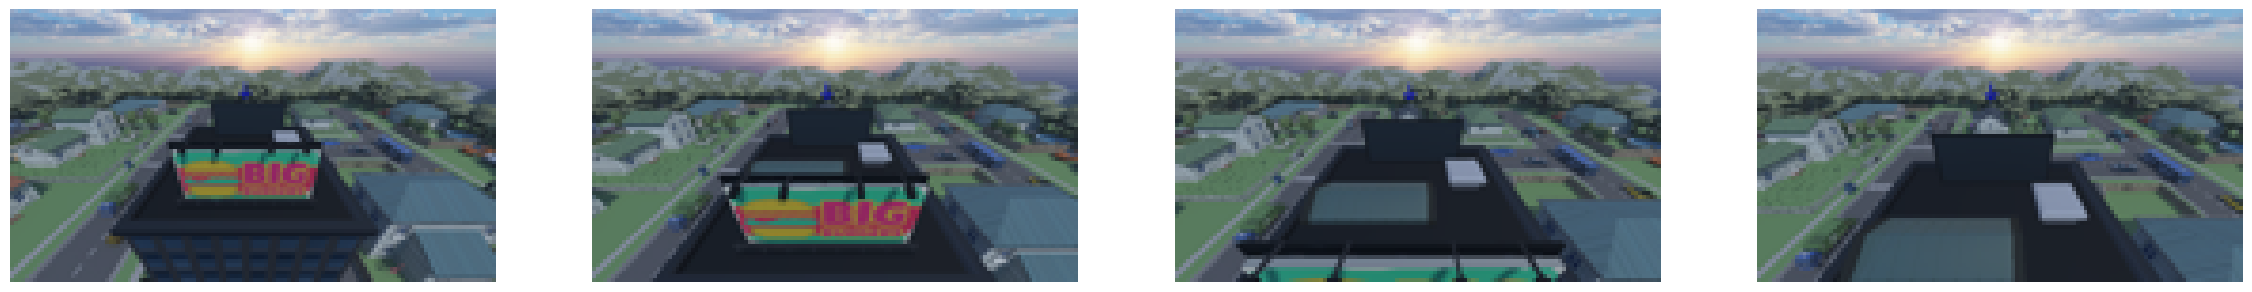

In [18]:
fig, axs = plt.subplots(ncols=4, figsize=(7.2*4, 12.8))

for ii, fname in enumerate(dict_png[run][list_idx[idx]]):
    ax = axs[ii]
    img = Image.open(fname)
    ax.imshow(img)
    ax.axis('off')

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/input_0.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

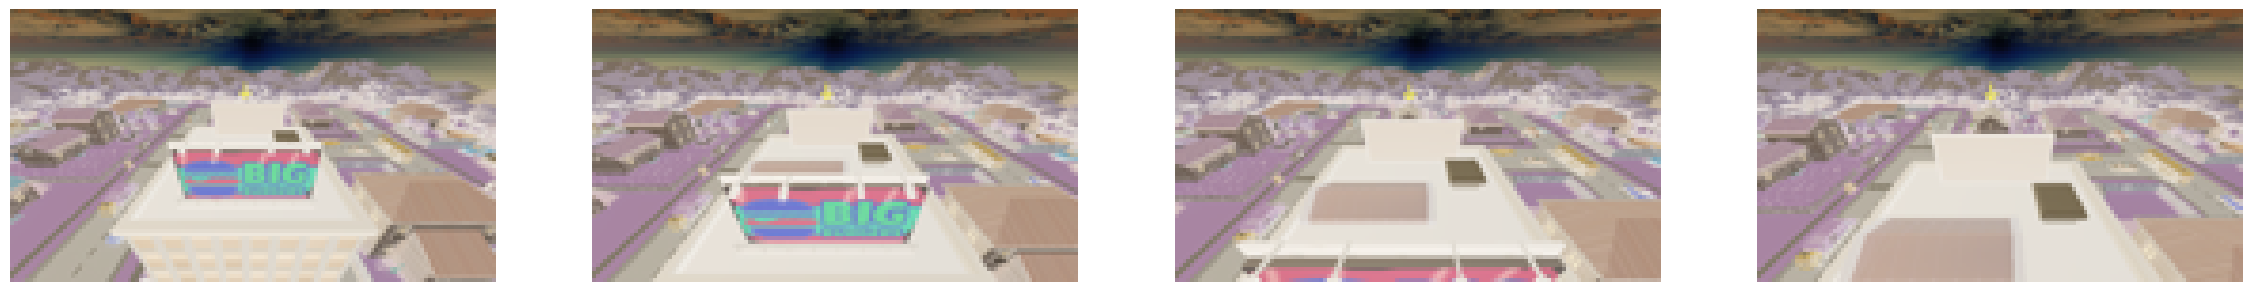

In [19]:
## input
fig, axs = plt.subplots(ncols=4, figsize=(7.2*4, 12.8))
for ii in range(4):
    ax = axs[ii]
    img = input_[idx][ii*3:(ii+1)*3]
    ax.imshow(np.transpose(img,(1,2,0)))
    ax.set_axis_off()
    
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/input_1.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

31x17x32
14x7x64
12x5x64
20.655245


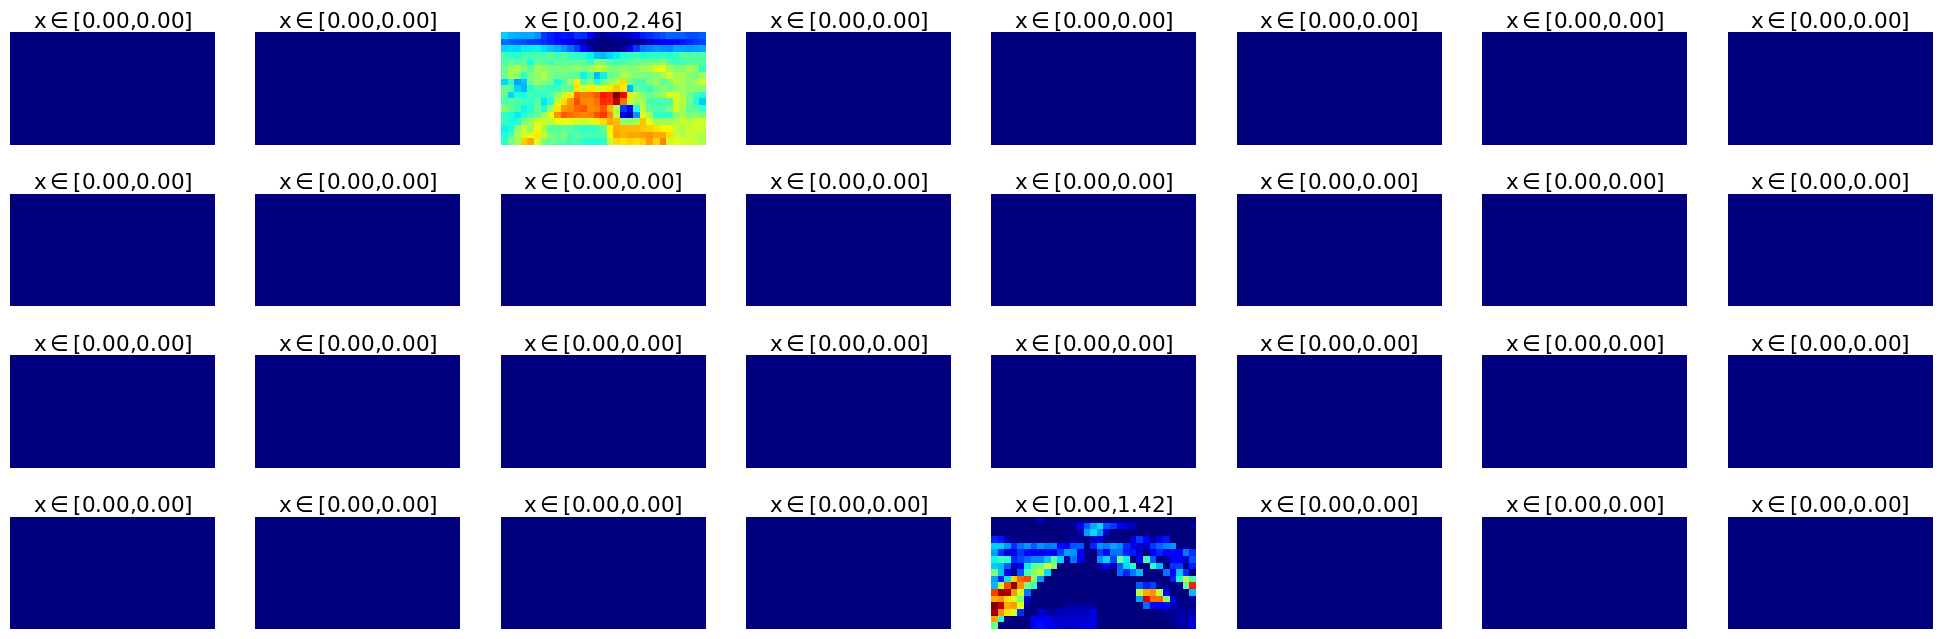

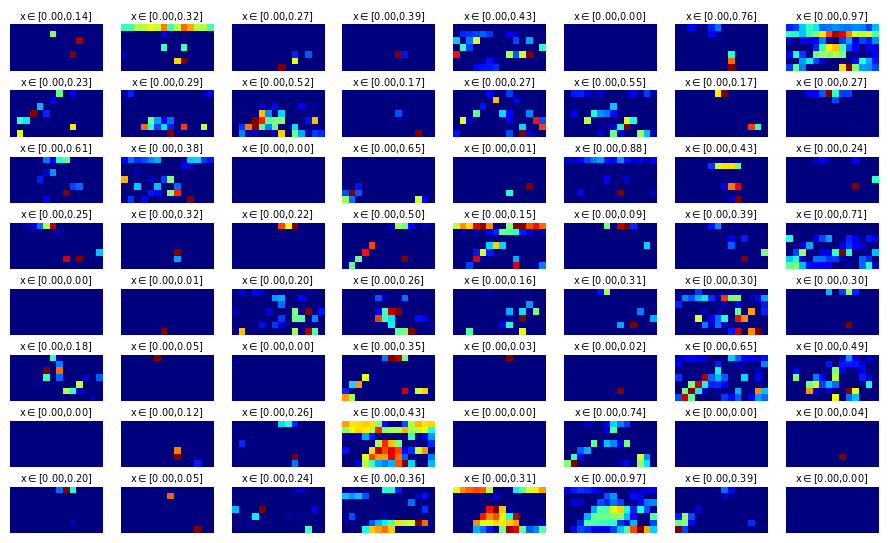

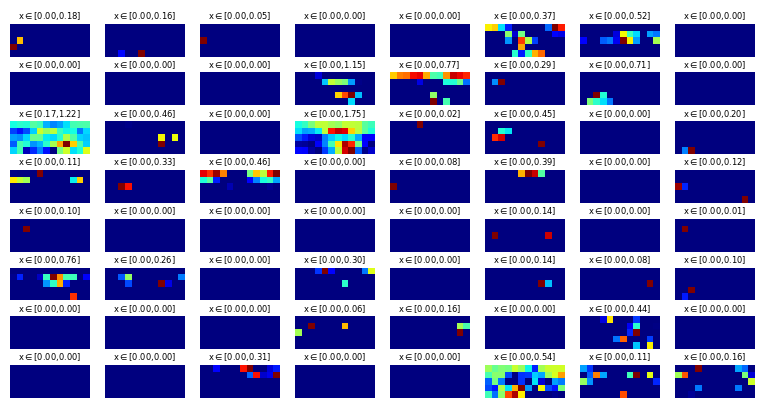

In [20]:
## output
for ii, cc in enumerate([conv1, conv2, conv3]):
    nfilters, height, width = cc.shape[1:]
    print('%dx%dx%d'%(width,height,nfilters))
    
    ncols = 8
    nrows = nfilters // ncols
    
    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows,
        figsize=(ncols*width*0.1, nrows*(height+width*0.1)*0.1)
    )
    axs = np.concatenate(axs)
    for jj, ax in enumerate(axs):
        img = cc[idx,jj].numpy()
        ax.imshow(
            img, cmap='jet',
#             vmin=0, vmax=5
        )
        ax.set_title(
            r'x$\in$[%.2f,%.2f]'%(float(img.min()),float(img.max())),
            fontdict={
                'fontsize':width*0.5,
                'horizontalalignment':'center',
                'verticalalignment':'center'
            }
        )
        ax.set_axis_off()
#     fig.savefig(
#         '/home/sungbeenpark/Github/labs/DRN/results/conv%d.png'%(ii+1),
#         dpi=300, facecolor=[1,1,1,0],
#         bbox_inches='tight'
#     )
    
print(val.numpy()[idx][0])

---